# Diabetes Prediction Model
This is partially based on J. Kurata's Pluralsight course.

## Imports

In [19]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.cross_validation
import sklearn.linear_model
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.preprocessing
import math

## Prepare the data

### Load from file

In [2]:
df = pd.read_csv("pima-data.csv")
print("Loaded DataFrame of size " + str(df.shape))

Loaded DataFrame of size (768, 10)


### Check for null and correlated values

In [3]:
print(df.isnull().any(axis=0))

num_preg        False
glucose_conc    False
diastolic_bp    False
thickness       False
insulin         False
bmi             False
diab_pred       False
age             False
skin            False
diabetes        False
dtype: bool


In [4]:
import matplotlib.pyplot as plt

corr = df.corr()
plt.matshow(corr)
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar()
plt.show() # Correlated features are colored yellow

<Figure size 480x480 with 2 Axes>

In [5]:
# Delete redundant 'skin' column
if 'skin' in df.columns:
    del df['skin']
col_names = df.columns.values

In [6]:
# Check for missing data hidden as zero values
(df == 0).astype(int).sum(axis=0) # sum across columns

num_preg        111
glucose_conc      5
diastolic_bp     35
thickness       227
insulin         374
bmi              11
diab_pred         0
age               0
diabetes        500
dtype: int64

### Convert non-numerical data

In [7]:
# Convert boolean column to int
df['diabetes'] = df['diabetes'].astype('int')
print(df.head())

   num_preg  glucose_conc  diastolic_bp  thickness  insulin   bmi  diab_pred  \
0         6           148            72         35        0  33.6      0.627   
1         1            85            66         29        0  26.6      0.351   
2         8           183            64          0        0  23.3      0.672   
3         1            89            66         23       94  28.1      0.167   
4         0           137            40         35      168  43.1      2.288   

   age  diabetes  
0   50         1  
1   31         0  
2   32         1  
3   21         0  
4   33         1  


### Check proportion of positives in data

In [8]:
def print_true_false_ratio(data):
    if type(data) == pd.DataFrame:
        count = { i:len(data.loc[data['diabetes'] == i]) for i in range(2) }
    elif type(data) == np.ndarray: # one-column numpy array
        count = { i:len(data[data == i]) for i in range(2) }
    total = count[0] + count[1]
    print(f"Number of positives: {count[1]} out of {total} ({count[1]*100.0/total:.2f}%).")
    print(f"Number of negatives: {count[0]} out of {total} ({count[0]*100.0/total:.2f}%).")
    
print_true_false_ratio(df)

Number of positives: 268 out of 768 (34.90%).
Number of negatives: 500 out of 768 (65.10%).


## Visualize the distribution of the features

In [9]:
features_means = { i: df[df['diabetes'] == i].iloc[:,:-1].mean(axis = 0) for i in range(2)}
features_stdevs = { i: df[df['diabetes'] == i].iloc[:,:-1].std(axis = 0) for i in range(2)}
stats = pd.DataFrame({'mean_healthy': features_means[0], 
                      'mean_diabetes': features_means[1], 
                      'std_healthy': features_stdevs[0], 
                      'std_diabetes': features_stdevs[1]})
print(stats)

              mean_healthy  mean_diabetes  std_healthy  std_diabetes
num_preg          3.298000       4.865672     3.017185      3.741239
glucose_conc    109.980000     141.257463    26.141200     31.939622
diastolic_bp     68.184000      70.824627    18.063075     21.491812
thickness        19.664000      22.164179    14.889947     17.679711
insulin          68.792000     100.335821    98.865289    138.689125
bmi              30.304200      35.142537     7.689855      7.262967
diab_pred         0.429734       0.550500     0.299085      0.372354
age              31.190000      37.067164    11.667655     10.968254


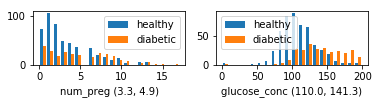

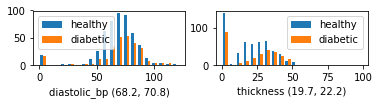

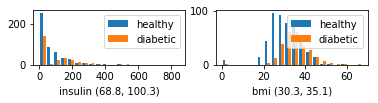

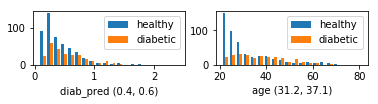

In [10]:
for i in range(4): # 4 rows in plot
    plt.figure(figsize=(6,1))
    for j in range(2): # 2 columns
        plt.subplot(1, 2, 1 + j) 
        plt.hist((df[df['diabetes']==0].iloc[:,2*i+j].values,df[df['diabetes']==1].iloc[:,2*i+j]), 
                 bins=20, label=('healthy','diabetic'));
        plt.xlabel(f"{df.columns[2*i+j]} ({stats.iloc[2*i+j,0]:.1f}, {stats.iloc[2*i+j,1]:.1f})");
        plt.legend();    

## Split the data into training and test sets

In [14]:
input_col_names = list(df.columns.values) # predictor columns
del input_col_names[input_col_names.index('diabetes')] # remove non-feature column
output_col_names = ['diabetes'] # output column
X = df[input_col_names].values # input data as ndarray
y = df[output_col_names].values # output data as ndarray
split_test_size = 0.3

X_train, X_test, y_train, y_test = sk.cross_validation.train_test_split(X, y, 
                                                                        test_size=split_test_size, 
                                                                        random_state=42)
print("Size and type of post-split data:\n",
      X_train.shape, type(X_train), "\n",
      X_test.shape, type(X_train), "\n",
      y_train.shape, type(y_train), "\n", 
      y_test.shape, type(y_test))


Size and type of post-split data:
 (537, 8) <class 'numpy.ndarray'> 
 (231, 8) <class 'numpy.ndarray'> 
 (537, 1) <class 'numpy.ndarray'> 
 (231, 1) <class 'numpy.ndarray'>


## Post-split data preparation

In [15]:
# Check that the proportion of True rows remains roughly unchanged
print("In training data:")
print_true_false_ratio(y_train)
print("In test data:")
print_true_false_ratio(y_test)

In training data:
Number of positives: 188 out of 537 (35.01%).
Number of negatives: 349 out of 537 (64.99%).
In test data:
Number of positives: 80 out of 231 (34.63%).
Number of negatives: 151 out of 231 (65.37%).


In [16]:
# Fix null values by replacing them with the mean
imputer = sk.preprocessing.Imputer(missing_values=0, strategy='mean', axis=0, verbose=1)
print("Number of zero values:", (X_train == 0).sum(axis=0), "and", (X_test == 0).sum(axis=0))
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

Number of zero values: [ 76   5  19 154 261   5   0   0] and [ 35   0  16  73 113   6   0   0]


In [17]:
print("Type of X_train and X_test after imputing:", type(X_train), ",", type(X_test))
print("Number of zero values (should now be 0):", (X_train == 0).sum(axis=0), "and", (X_test == 0).sum(axis=0))

Type of X_train and X_test after imputing: <class 'numpy.ndarray'> , <class 'numpy.ndarray'>
Number of zero values (should now be 0): [0 0 0 0 0 0 0 0] and [0 0 0 0 0 0 0 0]


## Train the Gaussian naïve Bayes model

In [20]:
nb_model = sk.naive_bayes.GaussianNB()
nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None)

In [21]:
# Display model parameters
print(nb_model.class_prior_)

[0.64990689 0.35009311]


## Evaluate performance of the model

In [22]:
y_train_predicted = nb_model.predict(X_train)
y_test_predicted = nb_model.predict(X_test)
print(f"Prediction accuracy on training data = {sk.metrics.accuracy_score(y_train, y_train_predicted):.4f}")
print(f"Prediction accuracy on test data = {sk.metrics.accuracy_score(y_test, y_test_predicted):.4f}")

Prediction accuracy on training data = 0.7542
Prediction accuracy on test data = 0.7359


In [23]:
print("Confusion matrix of training data (columns: predicted values, rows: actual values):")
confusion_train = sk.metrics.confusion_matrix(y_train, y_train_predicted)
print(confusion_train)

print("Confusion matrix of test data ([[TN FP][FN TP]]):")
confusion_test = sk.metrics.confusion_matrix(y_test, y_test_predicted)
TN = confusion_test[0, 0]
FP = confusion_test[0, 1]
FN = confusion_test[1, 0]
TP = confusion_test[1, 1]

print(confusion_test)

Confusion matrix of training data (columns: predicted values, rows: actual values):
[[293  56]
 [ 76 112]]
Confusion matrix of test data ([[TN FP][FN TP]]):
[[118  33]
 [ 28  52]]


In [24]:
print("Classification report of test data:")
print(sk.metrics.classification_report(y_test, y_test_predicted))
precision = TP/(TP+FP) # for recommendation model
print("Precision =", precision)
recall = TP/(FN+TP) # for disease modelling
print("Recall =", recall)
print("F1-score =", 1.0/((1.0/recall + 1.0/precision)/2))

Classification report of test data:
             precision    recall  f1-score   support

          0       0.81      0.78      0.79       151
          1       0.61      0.65      0.63        80

avg / total       0.74      0.74      0.74       231

Precision = 0.611764705882353
Recall = 0.65
F1-score = 0.6303030303030304


## Perform explicit calculation

In [34]:
def calc_gaussian_density(x, mean, stdev):
    exponent = math.exp(-(x-mean)**2/(2*stdev**2))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

y_train = y_train.squeeze() # remove unused 2nd dimension so that we can use y_train as a boolean mask
means = { i: X_train[y_train == i].mean(axis = 0) for i in range(2)}
stdevs = { i: X_train[y_train == i].std(axis = 0) for i in range(2)}

vect_density = np.vectorize(calc_gaussian_density)
prob_healthy = vect_density(X_train, means[0], stdevs[0])
prob_diabetes = vect_density(X_train, means[1], stdevs[1])
prob_healthy = prob_healthy.prod(axis=1) * len(y_train[y_train == 0]) / len(y_train)
prob_diabetes = prob_diabetes.prod(axis=1)* len(y_train[y_train == 1]) / len(y_train)
print("Same results as Scikit-Learn:", np.array_equal((prob_healthy < prob_diabetes).astype(int), y_train_predicted))

Same results as Scikit-Learn: True


# Simpler model: logistic regression (unbalanced & balanced)

## Calibrate C parameter

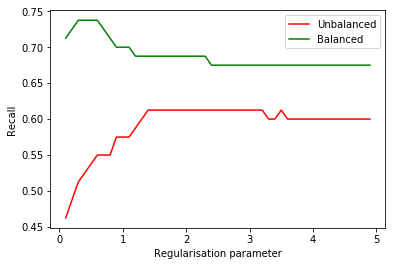

In [35]:
recall_results = []
recall_results_balanced = []
c_values = np.arange(0.1, 5, 0.1)
for c in c_values:
    # fit both a balanced and unbalanced model
    lr_model = sk.linear_model.LogisticRegression(C=c, random_state=42)    
    lr_model_balanced = sk.linear_model.LogisticRegression(C=c, random_state=42, class_weight='balanced')    
    lr_model.fit(X_train, y_train.ravel())
    lr_model_balanced.fit(X_train, y_train.ravel())
    # record recall score from test data in each case
    y_test_predicted_lr = lr_model.predict(X_test) 
    y_test_predicted_lr_balanced = lr_model_balanced.predict(X_test)     
    recall_results.append(sk.metrics.recall_score(y_test, y_test_predicted_lr))
    recall_results_balanced.append(sk.metrics.recall_score(y_test, y_test_predicted_lr_balanced))
# plot recall score as a function of C for both model types
r1, r2 = plt.plot(c_values, recall_results, 'r-', c_values, recall_results_balanced, 'g-')

plt.xlabel('Regularisation parameter');
plt.ylabel('Recall');
plt.legend([r1, r2], ["Unbalanced", "Balanced"]);

## Produce classification metrics with best model and C value

In [36]:
lr_model = sk.linear_model.LogisticRegression(C=0.3, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train.ravel())
y_train_predicted_lr = lr_model.predict(X_train)
y_test_predicted_lr = lr_model.predict(X_test)
print("Classification report of training data:")
print(sk.metrics.classification_report(y_train, y_train_predicted_lr))
print("Classification report of test data:")
print(sk.metrics.classification_report(y_test, y_test_predicted_lr))

Classification report of training data:
             precision    recall  f1-score   support

          0       0.85      0.74      0.79       349
          1       0.61      0.75      0.67       188

avg / total       0.76      0.74      0.75       537

Classification report of test data:
             precision    recall  f1-score   support

          0       0.83      0.70      0.76       151
          1       0.57      0.74      0.64        80

avg / total       0.74      0.71      0.72       231



## Repeat using cross-calibration

In [37]:
lr_model = sk.linear_model.LogisticRegressionCV(Cs=3, cv=10, n_jobs=-1, refit=False, 
                                                class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=3, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=False, scoring=None, solver='lbfgs', tol=0.0001,
           verbose=0)

In [43]:
print("Coefficients:", lr_model.coef_)
print("Regularisation parameters:", lr_model.Cs_)
print("Scores:", lr_model.scores_)

Coefficients: [[ 0.03803313  0.03548025 -0.00454891  0.01041579  0.00116897  0.05660721
   0.30450864  0.0279351 ]]
Regularisation parameters: [1.e-04 1.e+00 1.e+04]
Scores: {1: array([[0.87037037, 0.87037037, 0.83333333],
       [0.83333333, 0.83333333, 0.83333333],
       [0.75925926, 0.77777778, 0.77777778],
       [0.75925926, 0.77777778, 0.74074074],
       [0.72222222, 0.7037037 , 0.66666667],
       [0.81481481, 0.83333333, 0.81481481],
       [0.68518519, 0.7037037 , 0.7037037 ],
       [0.75925926, 0.7962963 , 0.7962963 ],
       [0.73584906, 0.73584906, 0.73584906],
       [0.71153846, 0.69230769, 0.69230769]])}


In [39]:
y_train_predicted_lr = lr_model.predict(X_train)
y_test_predicted_lr = lr_model.predict(X_test)
print("Classification report of training data:")
print(sk.metrics.classification_report(y_train, y_train_predicted_lr))
print("Classification report of test data:")
print(sk.metrics.classification_report(y_test, y_test_predicted_lr))

Classification report of training data:
             precision    recall  f1-score   support

          0       0.84      0.79      0.81       349
          1       0.65      0.73      0.69       188

avg / total       0.77      0.77      0.77       537

Classification report of test data:
             precision    recall  f1-score   support

          0       0.81      0.72      0.76       151
          1       0.56      0.69      0.62        80

avg / total       0.73      0.71      0.71       231

